In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [4]:
TRAIN_DIR = "/content/drive/MyDrive/new work/Dataset/train"
TEST_DIR  = "/content/drive/MyDrive/new work/Dataset/train"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_it = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_it = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 7597 images belonging to 4 classes.
Found 7597 images belonging to 4 classes.


In [6]:
class_names = list(train_it.class_indices.keys())
print("\nClass indices:", train_it.class_indices)
print("Class names:", class_names)


batchX, batchy = next(train_it)
print(f"\nBatch shape={batchX.shape}, y shape={batchy.shape}")
print(f"Batch min={batchX.min():.3f}, max={batchX.max():.3f}")


if len(class_names) != NUM_CLASSES:
    print(f"\n[Warning] Found {len(class_names)} classes in folders, but NUM_CLASSES={NUM_CLASSES}.")
    NUM_CLASSES = len(class_names)
    print(f"Setting NUM_CLASSES={NUM_CLASSES} based on folder structure.")


Class indices: {'Hyperpigmentation': 0, 'Nail fungus': 1, 'clubbing': 2, 'normal': 3}
Class names: ['Hyperpigmentation', 'Nail fungus', 'clubbing', 'normal']

Batch shape=(32, 224, 224, 3), y shape=(32, 4)
Batch min=-123.680, max=151.061


In [7]:
backbone = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
backbone.trainable = False

x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.30)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=backbone.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint("best_resnet50.keras", monitor="val_loss", save_best_only=True),
]

In [10]:
history = model.fit(
    train_it,
    validation_data=val_it,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 5293s 22s/step - accuracy: 0.6950 - loss: 0.7904 - val_accuracy: 0.9521 - val_loss: 0.1744 - learning_rate: 0.0010
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 156s 653ms/step - accuracy: 0.9190 - loss: 0.2260 - val_accuracy: 0.9743 - val_loss: 0.1055 - learning_rate: 0.0010
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 152s 636ms/step - accuracy: 0.9502 - loss: 0.1498 - val_accuracy: 0.9808 - val_loss: 0.0828 - learning_rate: 0.0010
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 152s 638ms/step - accuracy: 0.9619 - loss: 0.1335 - val_accuracy: 0.9882 - val_loss: 0.0626 - learning_rate: 0.0010
Epoch 5/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 150s 630ms/step - accuracy: 0.9632 - loss: 0.1087 - val_accuracy: 0.9896 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 6/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 158s 665ms/step - accuracy: 0.9720 - loss: 0.0934 - val_accuracy: 0.9899 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 7/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 148s 621ms/step - accurac

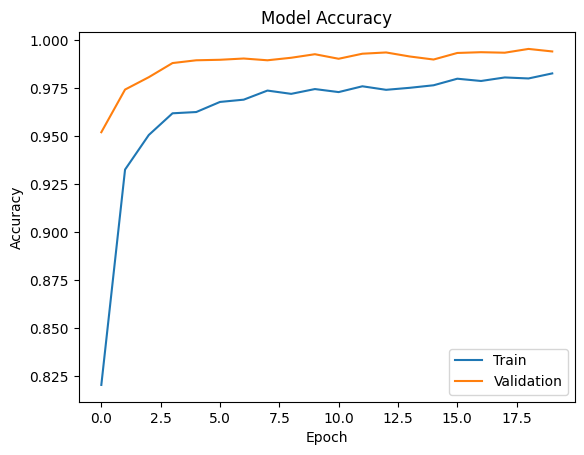

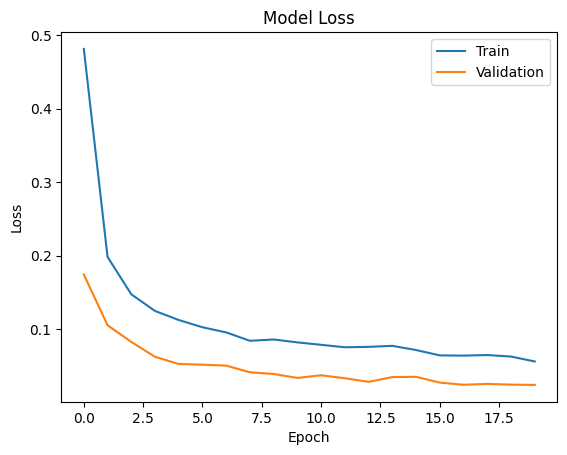

In [11]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="lower right")
plt.show()

plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()


238/238 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step


<Figure size 640x480 with 0 Axes>

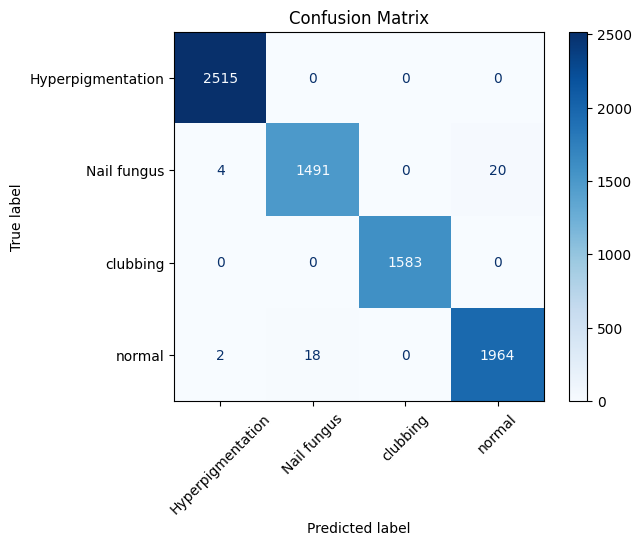

In [12]:
val_it.reset()

Y_pred = model.predict(val_it, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_it.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure()
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [13]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

                   precision    recall  f1-score   support

Hyperpigmentation       1.00      1.00      1.00      2515
      Nail fungus       0.99      0.98      0.99      1515
         clubbing       1.00      1.00      1.00      1583
           normal       0.99      0.99      0.99      1984

         accuracy                           0.99      7597
        macro avg       0.99      0.99      0.99      7597
     weighted avg       0.99      0.99      0.99      7597



In [14]:
val_loss, val_acc = model.evaluate(val_it, verbose=0)
print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss:     {val_loss:.4f}")



Final Validation Accuracy: 0.9942
Final Validation Loss:     0.0244


238/238 ━━━━━━━━━━━━━━━━━━━━ 37s 153ms/step


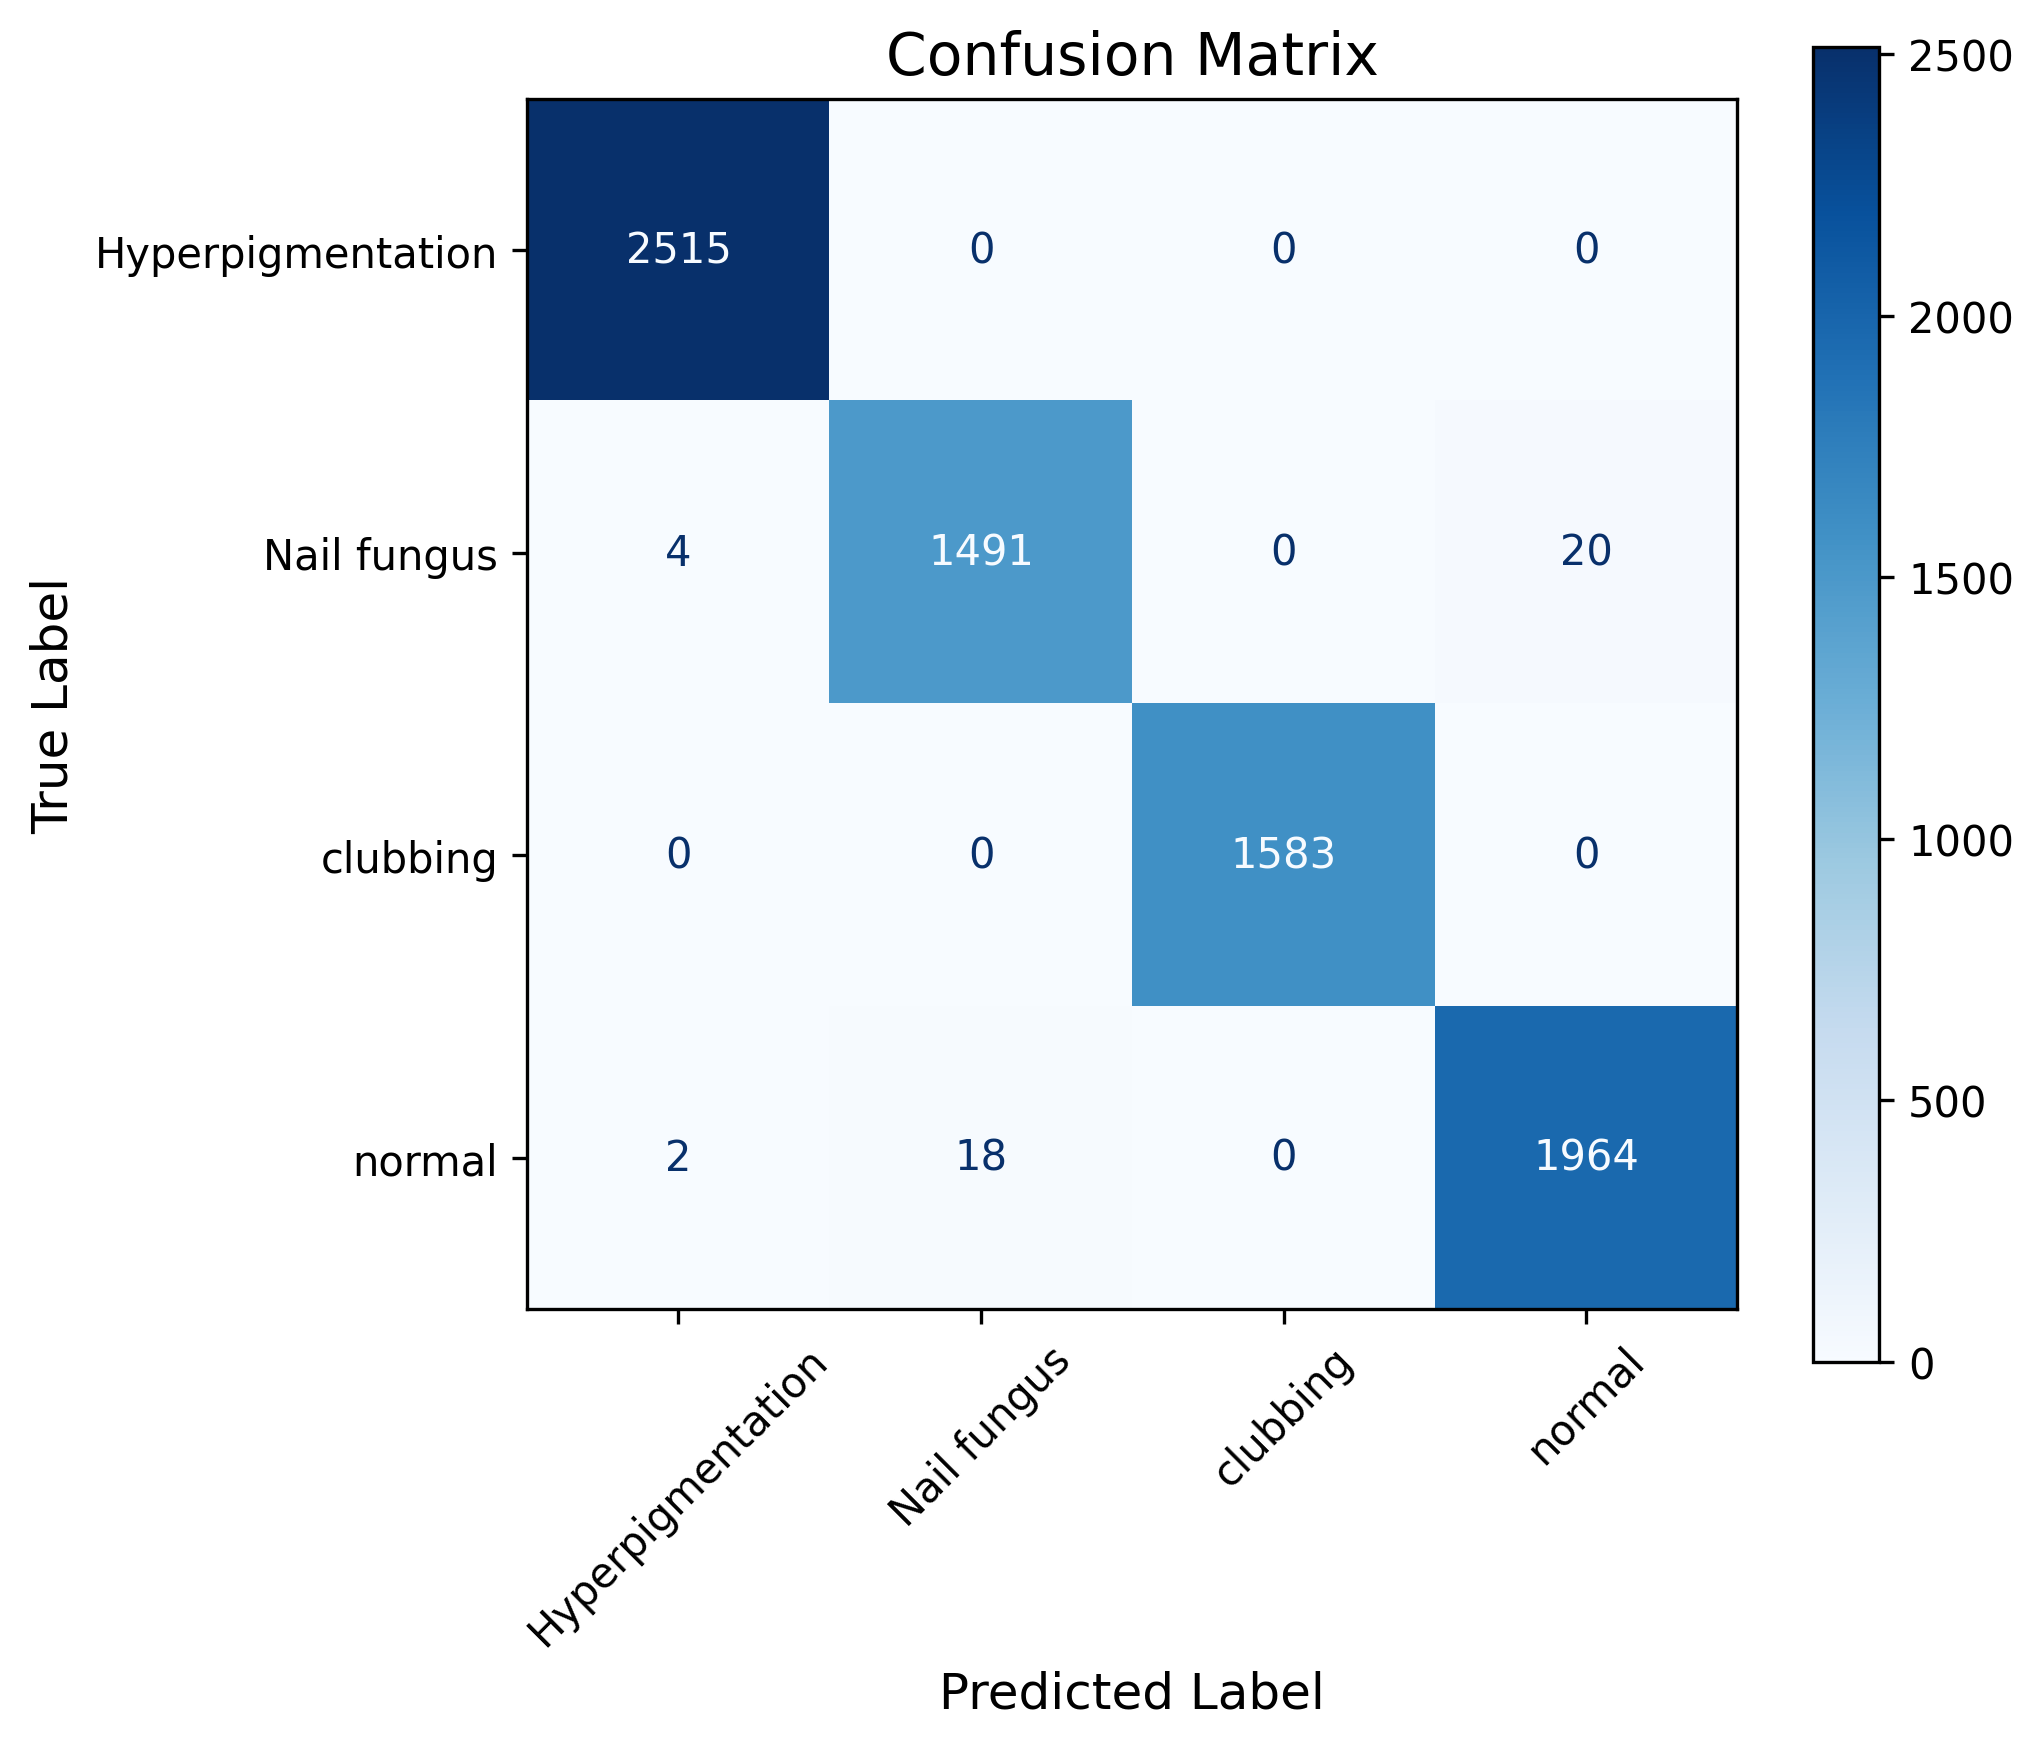


Classification Report:

                   precision    recall  f1-score   support

Hyperpigmentation     0.9976    1.0000    0.9988      2515
      Nail fungus     0.9881    0.9842    0.9861      1515
         clubbing     1.0000    1.0000    1.0000      1583
           normal     0.9899    0.9899    0.9899      1984

         accuracy                         0.9942      7597
        macro avg     0.9939    0.9935    0.9937      7597
     weighted avg     0.9942    0.9942    0.9942      7597


Classification Report:

                   precision    recall  f1-score   support

Hyperpigmentation       1.00      1.00      1.00      2515
      Nail fungus       0.99      0.98      0.99      1515
         clubbing       1.00      1.00      1.00      1583
           normal       0.99      0.99      0.99      1984

         accuracy                           0.99      7597
        macro avg       0.99      0.99      0.99      7597
     weighted avg       0.99      0.99      0.99      7597



In [15]:
# Reset generator
val_it.reset()

# Predictions
Y_pred = model.predict(val_it, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_it.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# High-quality figure
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(
    ax=ax,
    cmap="Blues",
    xticks_rotation=45,
    colorbar=True
)

ax.set_title("Confusion Matrix", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

plt.tight_layout()
plt.show()

# Classification report (console only)
print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

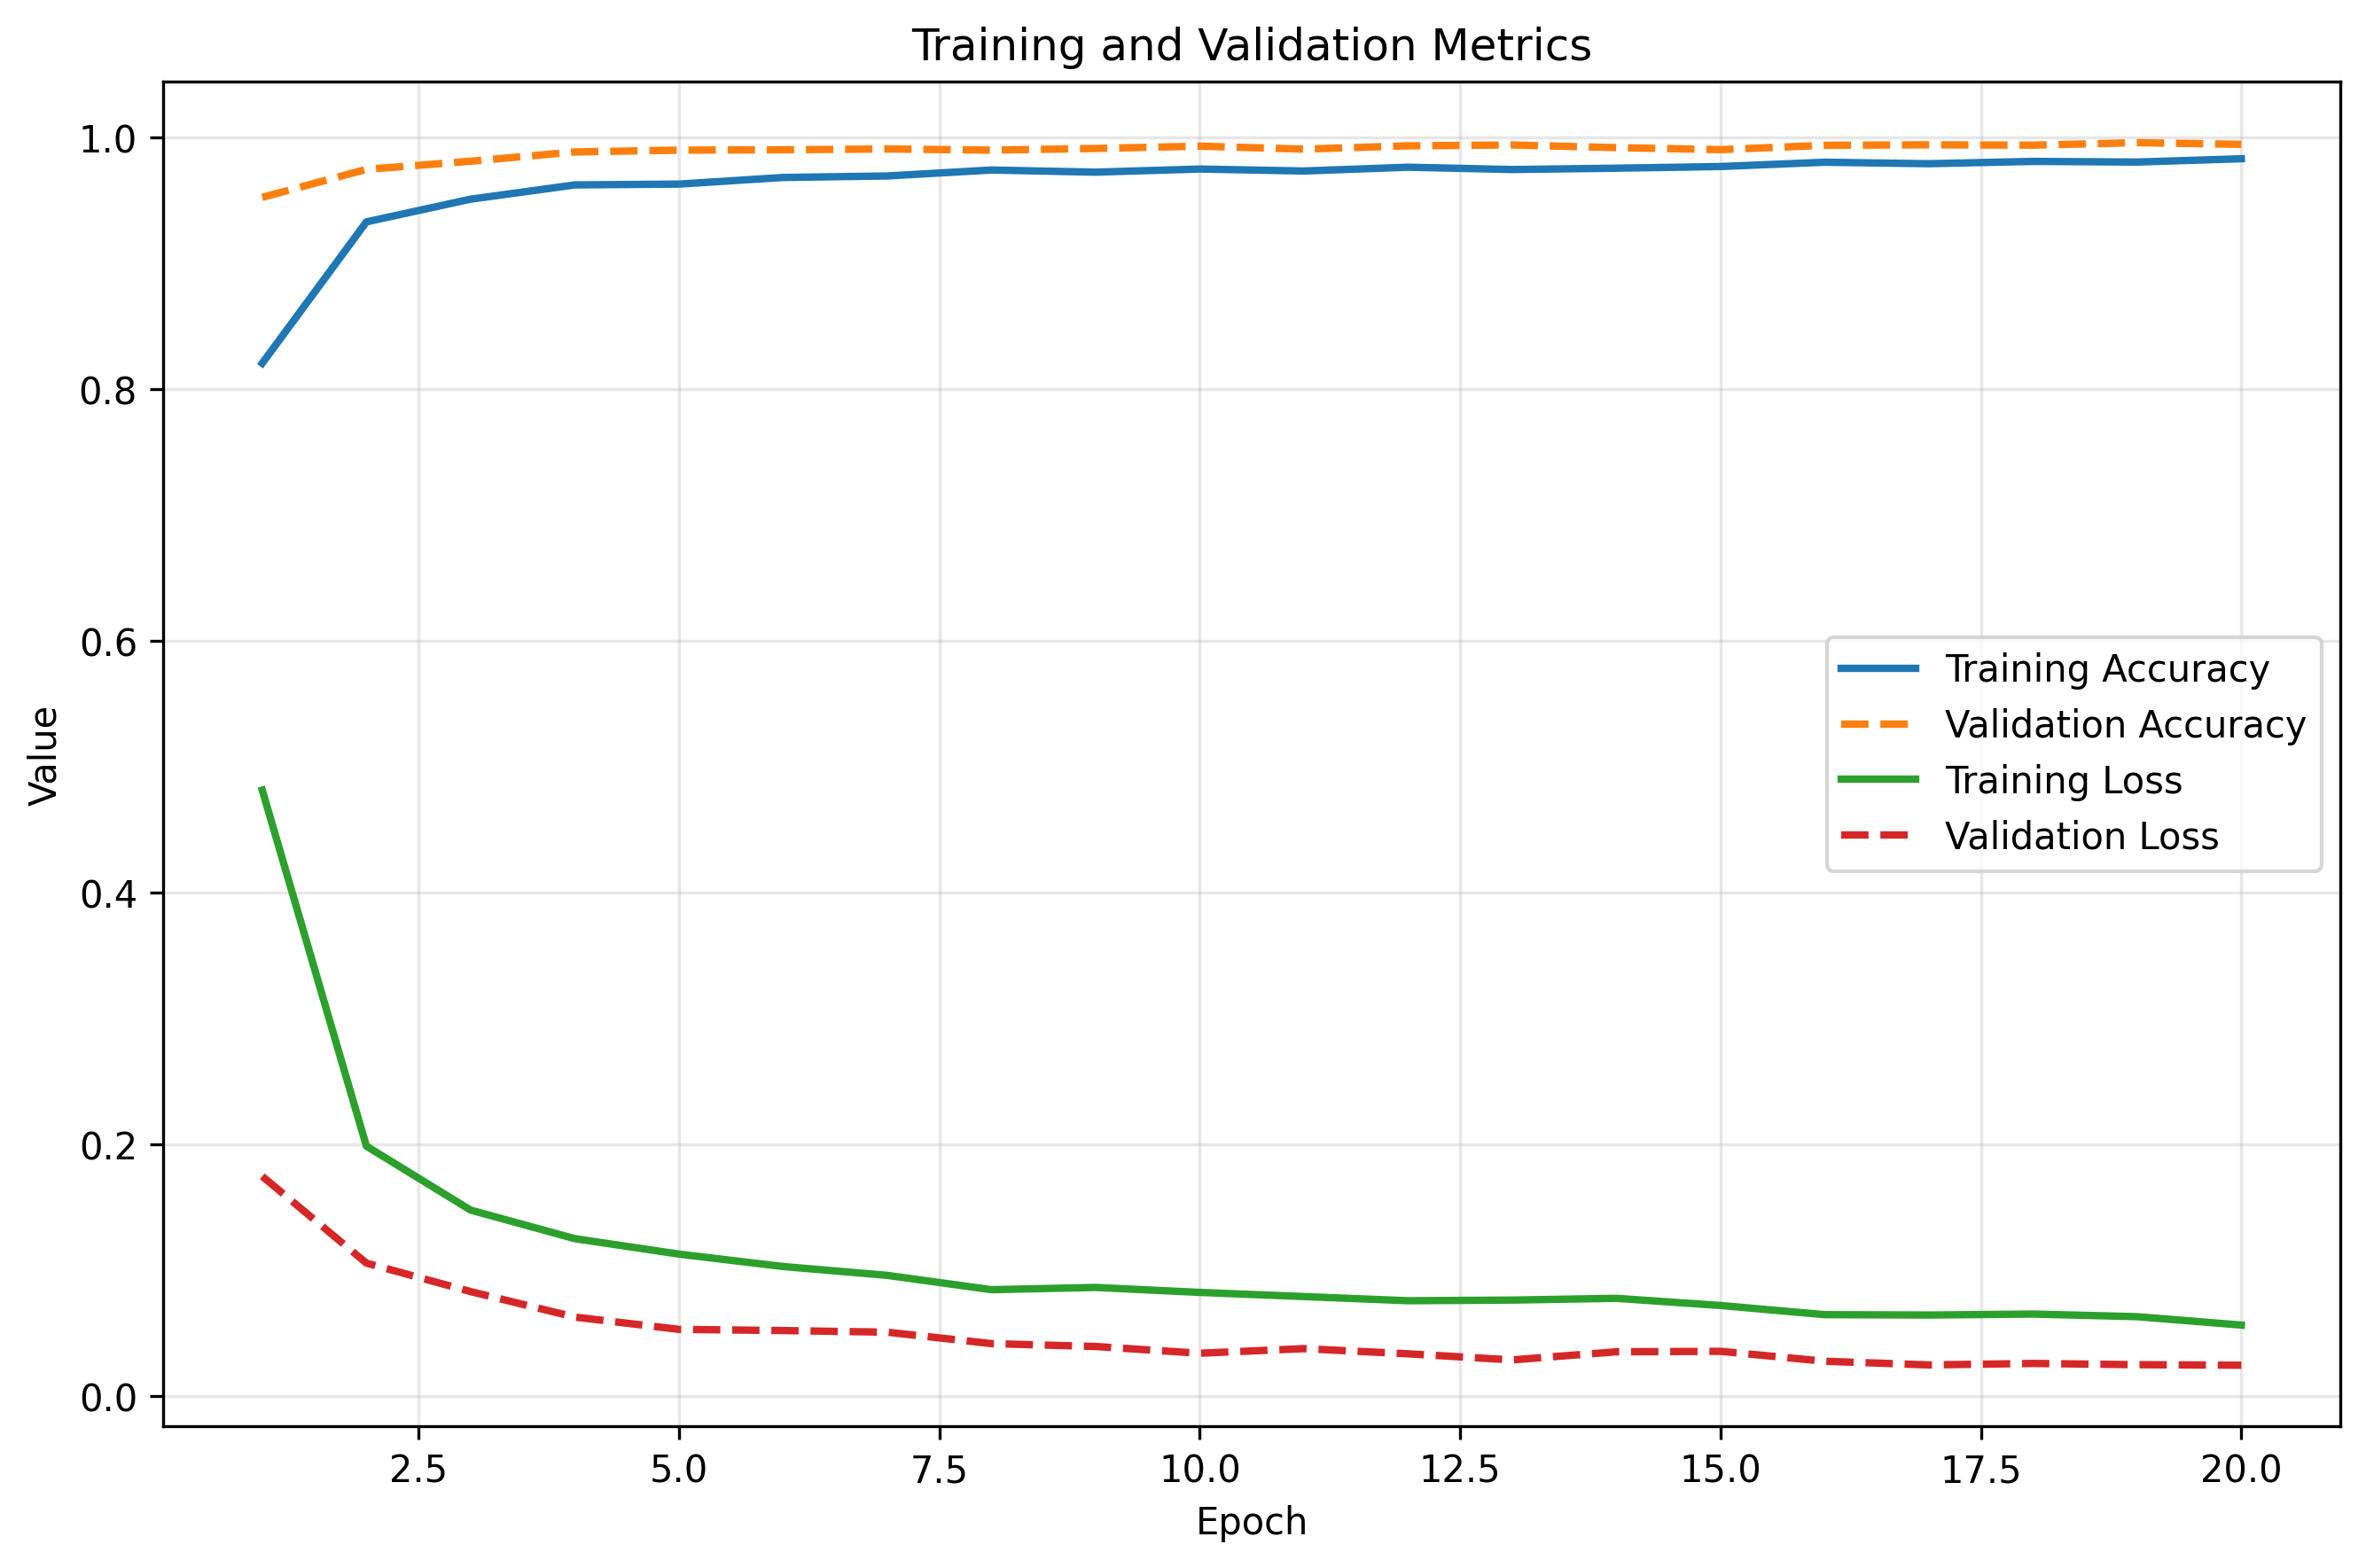

In [19]:
import matplotlib.pyplot as plt

# Extract history dictionary
hist = history.history

epochs = range(1, len(hist["accuracy"]) + 1)

plt.figure(figsize=(9, 6), dpi=300)

plt.plot(epochs, hist["accuracy"], label="Training Accuracy", linewidth=2)
plt.plot(epochs, hist["val_accuracy"], label="Validation Accuracy",
         linewidth=2, linestyle="--")

plt.plot(epochs, hist["loss"], label="Training Loss", linewidth=2)
plt.plot(epochs, hist["val_loss"], label="Validation Loss",
         linewidth=2, linestyle="--")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training and Validation Metrics")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_validation_all_metrics.png", dpi=300, bbox_inches="tight")
plt.savefig("training_validation_all_metrics.pdf", bbox_inches="tight")
plt.show()


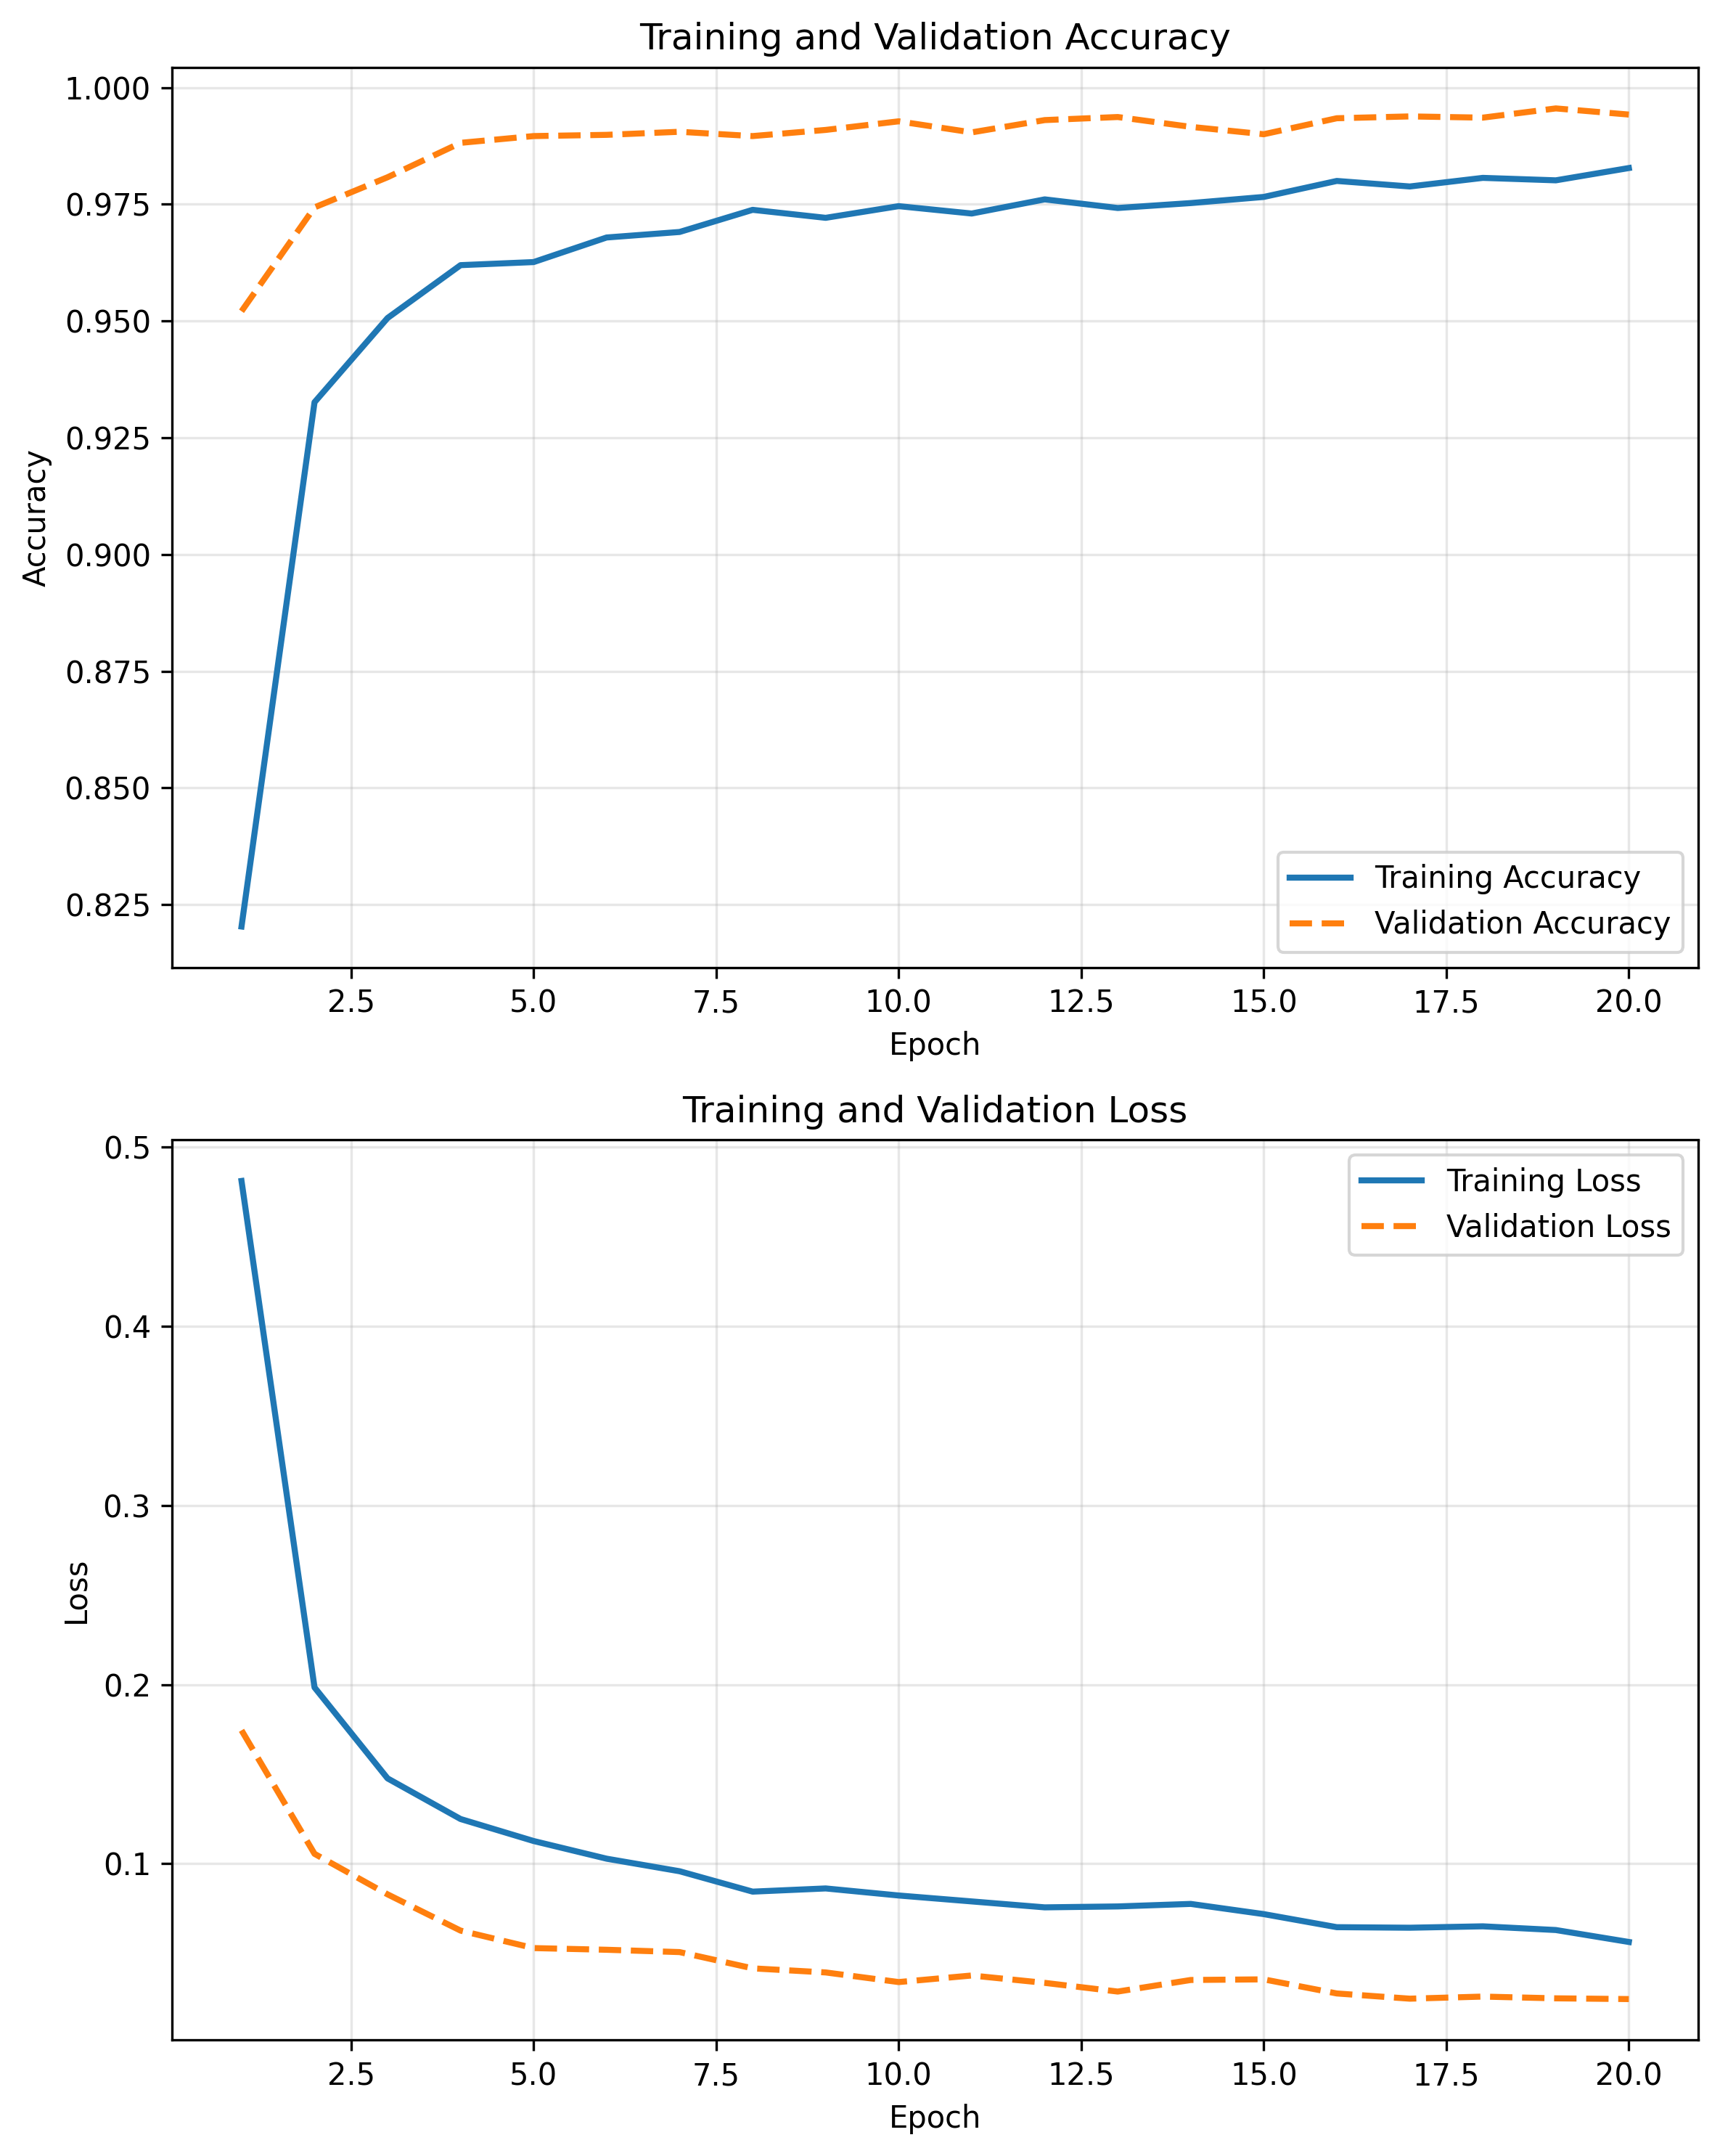

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist["accuracy"]) + 1)

plt.figure(figsize=(8, 10), dpi=300)

# -------- Accuracy --------
plt.subplot(2, 1, 1)
plt.plot(epochs, hist["accuracy"], label="Training Accuracy", linewidth=2)
plt.plot(epochs, hist["val_accuracy"], label="Validation Accuracy", linewidth=2, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# -------- Loss --------
plt.subplot(2, 1, 2)
plt.plot(epochs, hist["loss"], label="Training Loss", linewidth=2)
plt.plot(epochs, hist["val_loss"], label="Validation Loss", linewidth=2, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_validation_metrics.png", dpi=300, bbox_inches="tight")
plt.savefig("training_validation_metrics.pdf", bbox_inches="tight")
plt.show()
